##Modelo Predictivo de Prepagos Hipotecarios
# Análisis Exploratorio de Datos

El objetivo de este análisis es proporcionar una descripción general de los tipos de datos, así como estadísticas clave.

##Carga de información

Se cargan las librerías necesarias y el archivo con los datos.
En este proyecto tenemos dos archivos, el primero contiene la serie histórica de los prepagos realizados desde enero 2019 para los créditos hipotecarios, así como los datos de los clientes de cada crédito. El segundo archivo contiene el saldo insoluto de los créditos, en el mismo formato de serie histórica, contiene también los datos de los clientes por crédito.

Para el proyecto nos enfocaremos en el saldo de los prepagos, pues el saldo insoluto es para observar el prepago en proporción a su saldo.

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

In [257]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [258]:
# Cargar archivo Excel
file_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/Análisis exploratorio/datos.xlsx"
df_prepago = pd.read_excel(file_path, sheet_name="Prepago")
df_saldo = pd.read_excel(file_path, sheet_name="Saldo Insoluto")

##Estructura de los datos

La base de datos cuenta con 12,867 créditos. De cada uno de ellos se tienen las siguientes variables.

Variables Numéricas:
- 'pla_credit' - Número de crédito: identificador único para cada crédito.
- 'edad_cliente' - Edad del cliente
- 'cantidad_otorgada' - cantidad otorgada en el crédito o saldo insoluto inicial.
- 'enganche' - enganche otorgado para el crédito
- 'score' - score del cliente del buró de crédito.
- 'tasa' - tasa otorgada al cliente.
- 'plazo_original' - plazo en años a los que se otorgó el crédito.
- 'plazo_original_meses' - plazo en meses a los que se otorgó el crédito.
- 'prepago_total' - suma de todos los montos de prepago en la ventana de enero 2019 a diciembre 2024.
- 'fechas' en archivo de prepago - los cierres mensuales en la ventana de tiempo contienen el monto de prepago a dicha fecha. (Nota: viene NaN si ese crédito no estuvo activo a esa fecha, no es valor nulo como tal).
- 'fechas' en archivo de saldo - los cierres mensuales en la ventana de tiempo contienen el saldo insoluto a dicha fecha. (Nota: viene NaN si ese crédito no estuvo activo a esa fecha, no es valor nulo como tal).

Variables categóricas:
- 'estado_civil' - estado civil del cliente: soltero, casado, divorciado, unión libre o viudo.
- 'clasificacion' - clasificación del producto: vivienda, terrenos u otros.
- 'estado' - estado de la república en donde reside el cliente.
- 'estatus_dic' - VIGENTE si el crédito se encuentra vigente en diciembre de 2024, LIQUIDADO si el crédito ya fue liquidado.




In [259]:
display(df_prepago.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pla_credit            12867 non-null  int64  
 1   edad_cliente          12867 non-null  int64  
 2   estado_civil          12867 non-null  object 
 3   cantidad_otorgada     12867 non-null  float64
 4   enganche              12867 non-null  float64
 5   clasificacion         12867 non-null  object 
 6   score                 12867 non-null  int64  
 7   tasa                  12867 non-null  float64
 8   plazo_original        12867 non-null  int64  
 9   plazo_original_meses  12867 non-null  int64  
 10  estado                12867 non-null  object 
 11  prepago_total         12867 non-null  float64
 12  estatus_dic           12867 non-null  object 
 13  2019-01-31 00:00:00   2563 non-null   float64
 14  2019-02-28 00:00:00   2621 non-null   float64
 15  2019-03-31 00:00:00

None

In [260]:
display(df_saldo.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12867 entries, 0 to 12866
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   credito               12867 non-null  int64  
 1   edad_cliente          12867 non-null  int64  
 2   estado_civil          12867 non-null  object 
 3   cantidad_otorgada     12867 non-null  float64
 4   enganche              12867 non-null  float64
 5   clasificacion         12867 non-null  object 
 6   score                 12867 non-null  int64  
 7   tasa                  12867 non-null  float64
 8   plazo_original        12867 non-null  int64  
 9   plazo_original_meses  12867 non-null  int64  
 10  estado                12867 non-null  object 
 11  prepago_total         12867 non-null  float64
 12  estatus_dic           12867 non-null  object 
 13  2019-01-31 00:00:00   2563 non-null   float64
 14  2019-02-28 00:00:00   2622 non-null   float64
 15  2019-03-31 00:00:00

None

Como trabajaremos primero observando las características del crédito, definimos 'df' como el data frame que incluye estas variables (excluyendo las de la serie de tiempo).

In [261]:
df = df_prepago.iloc[:, :13]
df.head()

,pla_credit,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,plazo_original_meses,estado,prepago_total,estatus_dic
0,1000190116002,41,SOLTERO,10000000.0,23131000.0,otros,705,8.55,19,228,NUEVO LEON,0.00,VIGENTE
1,1008720301002,56,CASADO,3240000.0,760000.0,Adquisicion de vivienda,697,9.40,15,180,NUEVO LEON,54778.05,VIGENTE
2,1017890120001,53,CASADO,1535100.0,270900.0,Adquisicion de vivienda,704,10.25,20,240,NUEVO LEON,40000.00,VIGENTE
3,1024481138003,57,CASADO,6000000.0,7030000.0,Adquisicion de vivienda,668,11.50,20,240,NUEVO LEON,0.00,LIQUIDADO
4,1024481146002,57,CASADO,6000000.0,7030000.0,Adquisicion de vivienda,668,11.50,20,240,NUEVO LEON,0.00,LIQUIDADO


Además, crearemos la variable binaria "prepago_diciembre", que marcará como 1 los créditos con prepagos en diciembre. Esta será la variable objetivo del modelo predictivo en su primera fase.

In [262]:
#creamos la variable que marca si hubo prepago en diciembre

df["prepago_dic"] = (df_prepago.iloc[:,84] > 0).astype(int)
df["prepago_dic"].head()

,prepago_dic
0,0
1,0
2,0
3,0
4,0


Después de conocer la estructura general de las variables, comprobamos que no existen valores nulos.

In [263]:
display(df.isnull().sum())

,0
pla_credit,0
edad_cliente,0
estado_civil,0
cantidad_otorgada,0
enganche,0
clasificacion,0
score,0
tasa,0
plazo_original,0
plazo_original_meses,0


In [264]:
num_vars = ["edad_cliente","cantidad_otorgada","enganche","score","tasa","plazo_original", "prepago_total"]
cat_vars = ["estado_civil","clasificacion", "estado", "estatus_dic", "prepago_dic"]

Ahora obtenemos estadísticas clave para las variables numéricas.

- 'edad_cliente': van de 18 a 82 años, con un promedio de 42.
- 'cantidad_otorgada': de 120 mil pesos a 28 millones de pesos, con un promedio de 1.8 millones.
- 'enganche': 34 mil pesos a 56 millones.
- 'score': de -8 a 778 con promedio de 596. Cabe mencionar que los scores negativos indican falta de historial crediticio, por lo que más adelante se observará la distribución en un histograma.
- 'tasa': de 0 a 14, con promedio de 10.5.
- 'plazo_original': de 0 a 23 años, con promedio de 14.7 años.
- 'prepago_total': de 0 a 21 millones, con promedio de 559 mil pesos.

In [265]:
df[num_vars].describe()

,edad_cliente,cantidad_otorgada,enganche,score,tasa,plazo_original,prepago_total
count,12867.000000,1.286700e+04,1.286700e+04,12867.000000,12867.000000,12867.000000,1.286700e+04
mean,42.011813,1.863573e+06,1.486361e+06,595.622756,10.488266,14.698065,5.589696e+05
std,10.214862,1.933726e+06,3.062039e+06,237.363457,0.816801,4.612583,1.183629e+06
min,18.000000,1.200000e+05,3.405000e+04,-8.000000,0.000000,0.000000,0.000000e+00
25%,34.000000,8.000000e+05,3.173550e+05,652.000000,9.900000,10.000000,0.000000e+00
50%,40.000000,1.293868e+06,6.423440e+05,691.000000,10.600000,15.000000,9.161100e+03
75%,49.000000,2.134800e+06,1.377950e+06,712.000000,11.000000,19.000000,7.152998e+05
max,82.000000,2.802000e+07,5.557400e+07,778.000000,14.000000,23.000000,2.086977e+07


Ahora obtenemos frecuencias para las variables categóricas.

- 'estado_civil' - el estado civil más común es CASADO, con 6,647 observaciones, seguido de SOLTERO, con 5,834.  Estos dos juntan el 97% del total.
- 'clasificacion' - El más común es terrenos, con 8,677. Después vivienda, con 2,988 y al final "Otros" con 1,202.
- 'estado' - los 3 estados principales son Nuevo León, Jalisco y Querétaro.
- 'estatus_dic' - Del total de créditos, 7,550 están vigentes en diciembre 2024.
- 'prepago_dic' - Por último, 433 créditos prepagaron a diciembre, de 7,550 vigentes a esta fecha (es decir, un 6%)

In [266]:
for col in cat_vars:
    print(f"\nFrecuencias de {col}:")
    print(df[col].value_counts())


Frecuencias de estado_civil:
estado_civil
CASADO         6647
SOLTERO        5834
DIVORCIADO      191
UNION LIBRE     146
VIUDO            49
Name: count, dtype: int64

Frecuencias de clasificacion:
clasificacion
Adquisicion de terrenos    8677
Adquisicion de vivienda    2988
otros                      1202
Name: count, dtype: int64

Frecuencias de estado:
estado
NUEVO LEON                         4223
JALISCO                            1742
QUERETARO                           825
COAHUILA DE ZARAGOZA                750
AGUASCALIENTES                      690
GUANAJUATO                          621
SAN LUIS POTOSI                     544
SONORA                              532
ESTADO DE MEXICO                    456
CIUDAD DE MEXICO                    427
PUEBLA                              328
TAMAULIPAS                          292
BAJA CALIFORNIA                     285
CHIHUAHUA                           271
YUCATAN                             172
ZACATECAS                        

##Análisis Univariante

En este apartado se emplearán técnicas de visualización en función del tipo de variable. Comenzaremos con histogramas y boxplots de las variables numéricas.

- la edad se concentra en 35-50 años, no se ven outliers o datos atípicos muy pronunciados, y la distribución se ve sesgada a la izquierda.
- la cantidad otorgada se concentra en cifras menores a 3 millones de pesos, son realtivamente pocos los casos mayores a 10 millones.
- el enganche tiene mucha variación, los valores se encuentran menores a 50 mil pesos.
- el score se concentra en el valor 700, con una cantidad importante de clientes sin suficiente historial (valores 0 o menores a 0).
- la tasa se concentra en valores de 10 y 11, con datos atípicos con tasa 0.
- el plazo original tiene valores específicos muy marcados, como 10, 15 y 20 años.
- el prepago total se concentra en valores menor a 1 millón de pesos, pero alcanza hasta 21 millones.

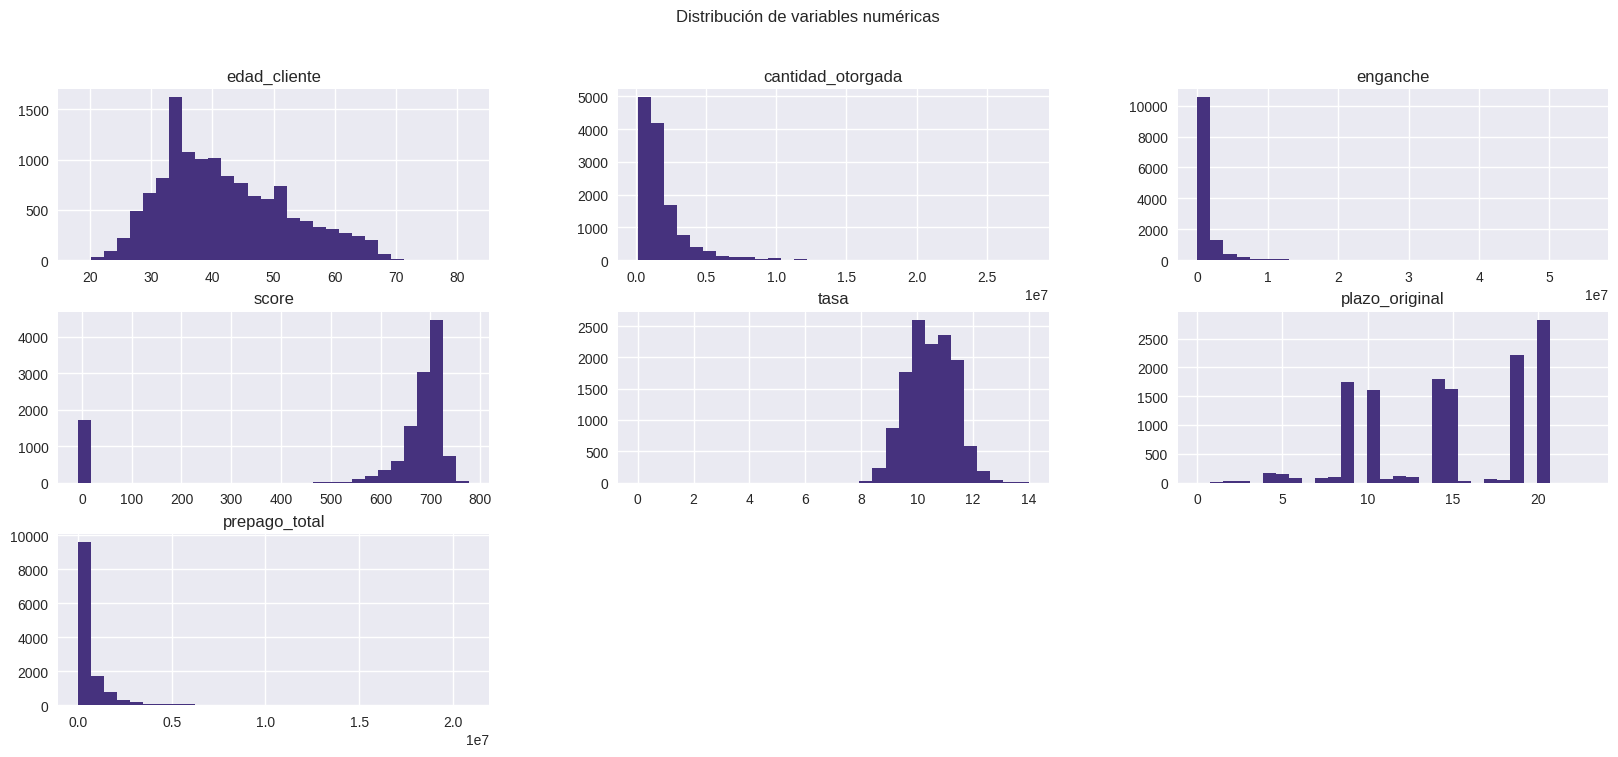

In [267]:
df[num_vars].hist(bins=30, figsize=(20,8), layout=(3,3))
plt.suptitle("Distribución de variables numéricas")
plt.show()

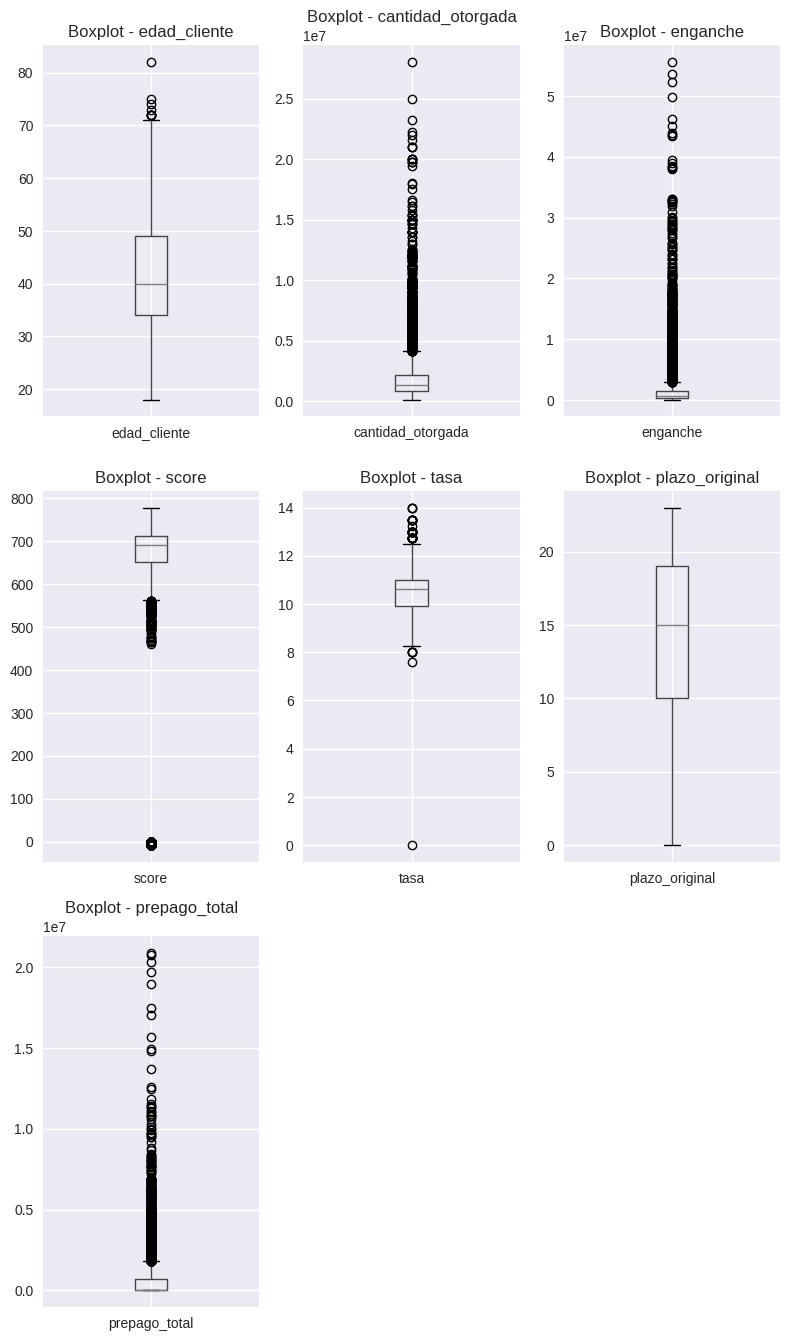

In [268]:
fig, axes = plt.subplots(9, 3, figsize=(8, 40))
axes = axes.flatten()

# Generar un boxplot por variable
for i, var in enumerate(num_vars):
    df.boxplot(column=var, ax=axes[i])
    axes[i].set_title(f"Boxplot - {var}")

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Observamos con mayor detalle el valor atípico de la tasa 0.

In [269]:
df[df["tasa"] == 0]

,pla_credit,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,plazo_original_meses,estado,prepago_total,estatus_dic,prepago_dic
8289,200940090040002,30,SOLTERO,1600000.0,1908000.0,otros,0,0.0,20,240,AGUASCALIENTES,0.0,LIQUIDADO,0


Observaremos con mayor detalle la distribución de los score excluyendo los valores 0 (clientes sin suficiente historial crediticio).

Observamos que se concentran alrededor del 675-725.

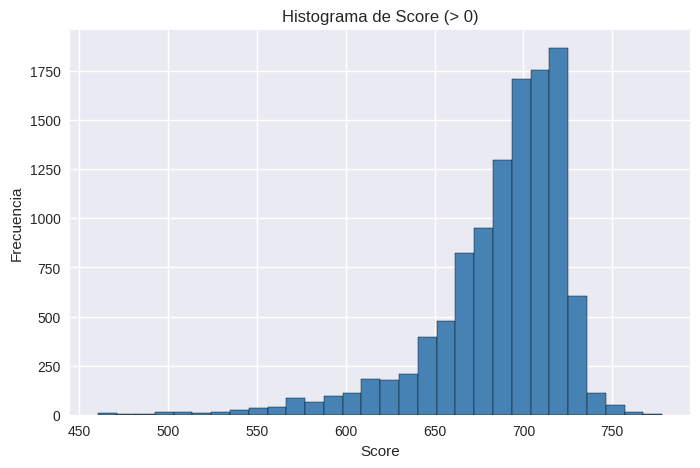

In [270]:
plt.figure(figsize=(8,5))
plt.hist(df[df["score"] > 0]["score"], bins=30, color="steelblue", edgecolor="black")
plt.title("Histograma de Score (> 0)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.show()

Para observar los prepagos en funnción de la cantidad otorgada, para evitar sesgo, obtenemos el siguiente histograma, en el que se observa un grupo de créditos que prepagan el 100% del crédito.

Cuando prepagan por arriba del 100% es porque considera los intereses generados.

Algunos de estos casos pueden ser principalmente relevantes para el banco, pues pueden provenir de clientes que transifirieron su crédito a otro banco (por lo general estos créditos tienen solamente 1 prepago en toda su vida y es cercano al 100%).

Otro grupo de créditos se concentra en valores de 0 (quienes no prepagan), y el resto se distribuye uniformemente de 0 a 90 aproximadamente (probablemente en función de la vida transcurrida del crédito).

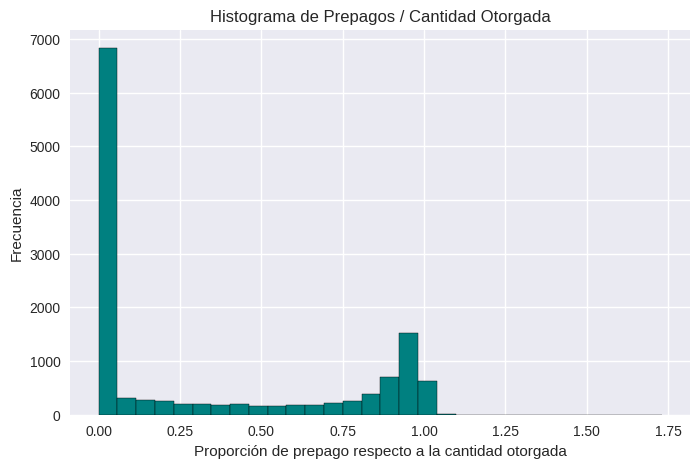

In [271]:
df["prepago_ratio"] = df["prepago_total"] / df["cantidad_otorgada"]

plt.figure(figsize=(8,5))
plt.hist(df["prepago_ratio"], bins=30, color="teal", edgecolor="black")
plt.title("Histograma de Prepagos / Cantidad Otorgada")
plt.xlabel("Proporción de prepago respecto a la cantidad otorgada")
plt.ylabel("Frecuencia")
plt.show()

Similar al análisis anterior, se debe observar el enganche en función del valor de la propiedad, esta la obtendremos sumando la cantidad otorgada y el mismo enganche.

En el siguiente histograma se puede observar que el porcentaje de enganche sobre el valor de la propiedad tiene una distribución muy sesgada a la izquierda, concentrándose en valores del 20% y 40%, siendo el máximo hasta cerca de 90%.

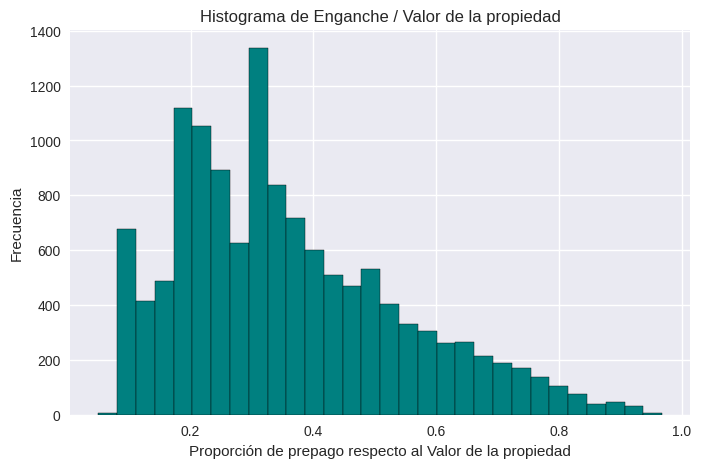

In [272]:
df["enganche_ratio"] = df["enganche"] / (df["cantidad_otorgada"] + df["enganche"])

plt.figure(figsize=(8,5))
plt.hist(df["enganche_ratio"], bins=30, color="teal", edgecolor="black")
plt.title("Histograma de Enganche / Valor de la propiedad")
plt.xlabel("Proporción de prepago respecto al Valor de la propiedad")
plt.ylabel("Frecuencia")
plt.show()

Continuando ahora con las variables categóricas se observa lo siguiente:

- el estado civil es principalmente CASADO o SOLTERO, siendo pocos los casos de DIVORCIADO, UNION LIBRE y VIUDO.
- la principal clasificación es de Terrenos, seguido por Vivienda y finalmente Otros.
- Los 3 estados principales son Nuevo León, Jalisco y Querétaro.
- Del total de créditos, 7,550 están vigentes en diciembre 2024.

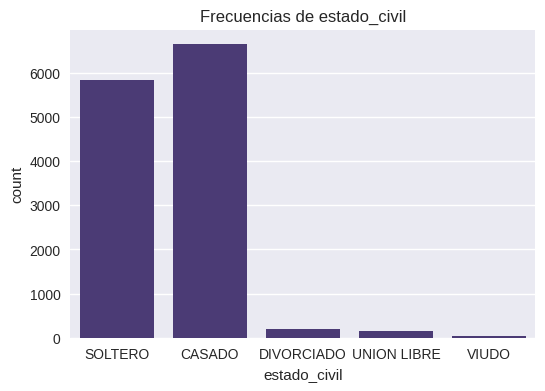

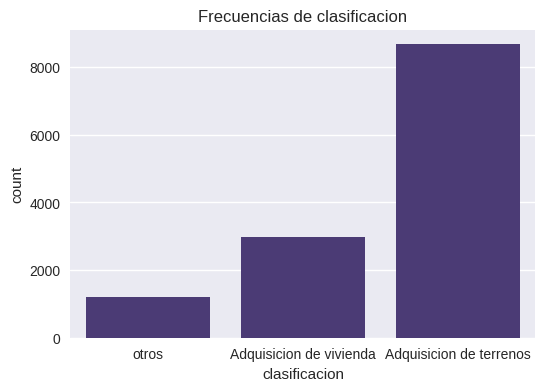

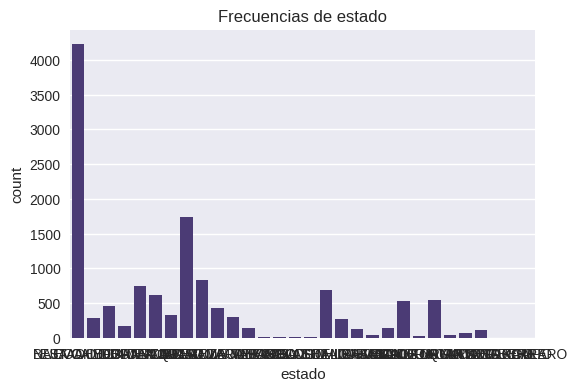

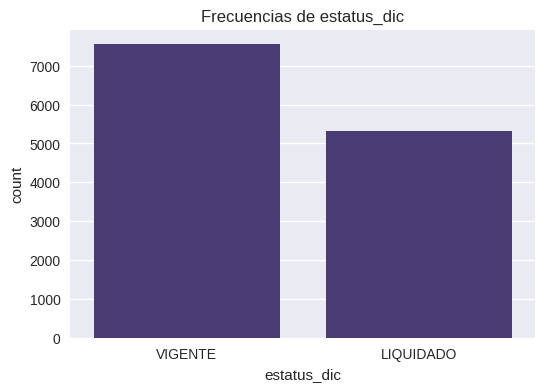

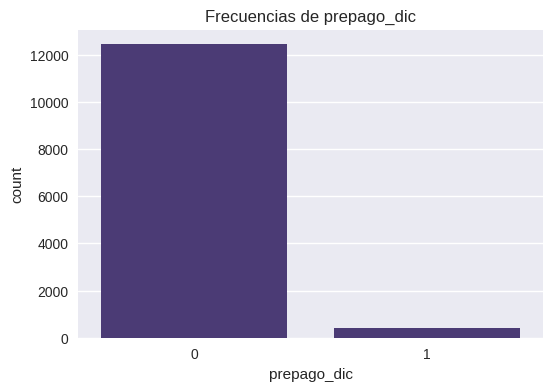

In [273]:
for col in cat_vars:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Frecuencias de {col}")
    plt.show()

Antes de continuar, observamos la distribución de las variables de únicamente los créditos vigentes a diciembre.

Se concluye que a nivel general cuentan con distribuciones similares.

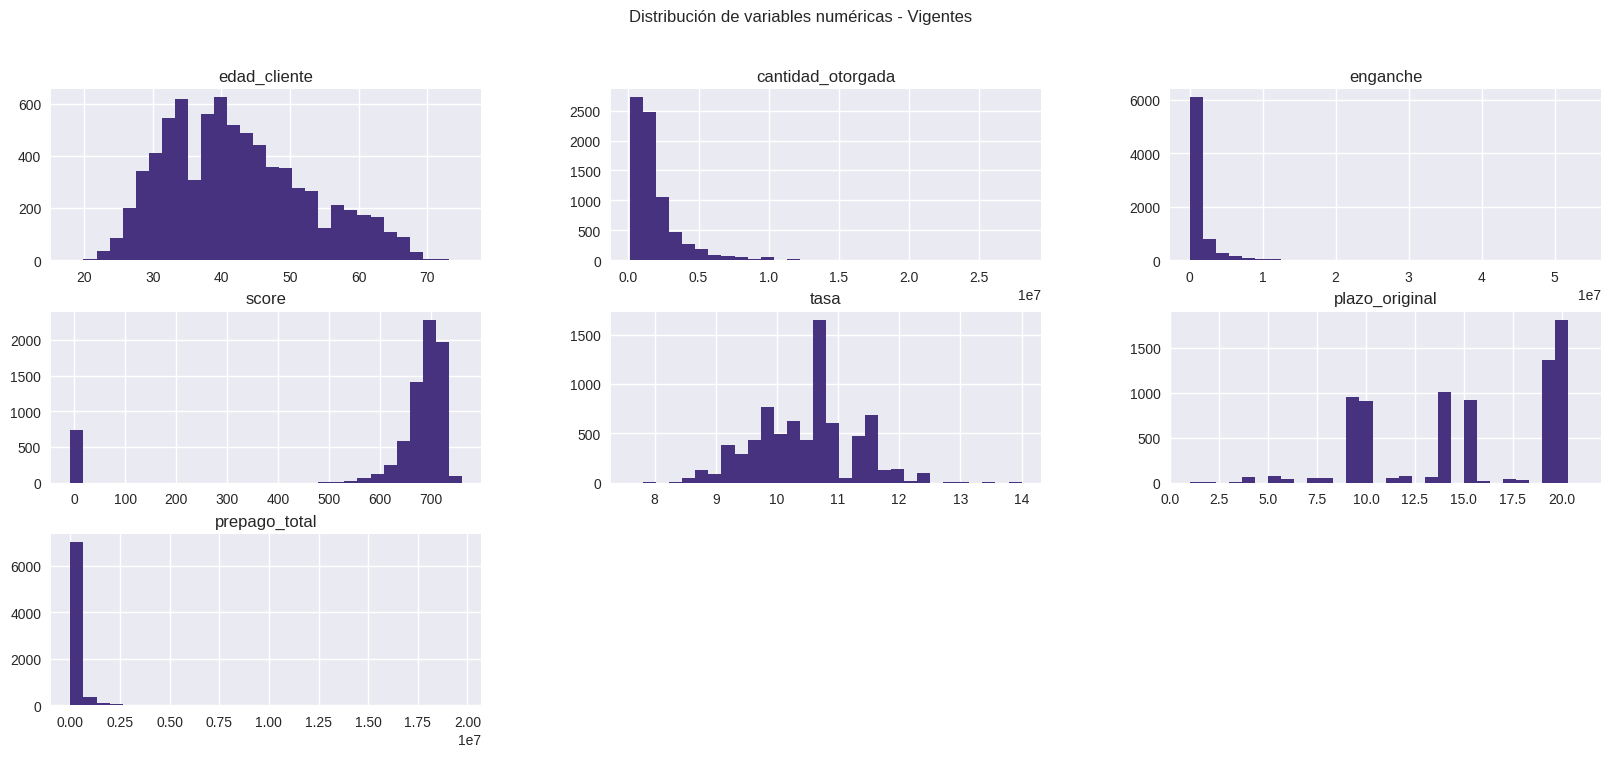

In [274]:
df_vigentes = df[df["estatus_dic"] == "VIGENTE"]
df_liquidados = df[df["estatus_dic"] == "LIQUIDADO"]

df_vigentes[num_vars].hist(bins=30, figsize=(20,8), layout=(3,3))
plt.suptitle("Distribución de variables numéricas - Vigentes")
plt.show()

Por último, observamos las series de tiempo de los prepagos, saldos insolutos y tasa de prepago (definida como el monto total de prepago entre el saldo).

Observamos un pico importante en el monto de prepago a finales de 2020, comportamiento ocasionado probablemente por la pandemia de COVID.

El saldo insoluto crece sostenidamente de manera lineal, sin ciclos estacionales evidentes.

La tasa de prepago se meustra relativamente estable, fluctuando entre 1% y 3%, con una tendencia a la baja a partir de 2021. Los picos no parecen seguir una periodicidad, por lo que no se logra identificar una estacionalidad clara.

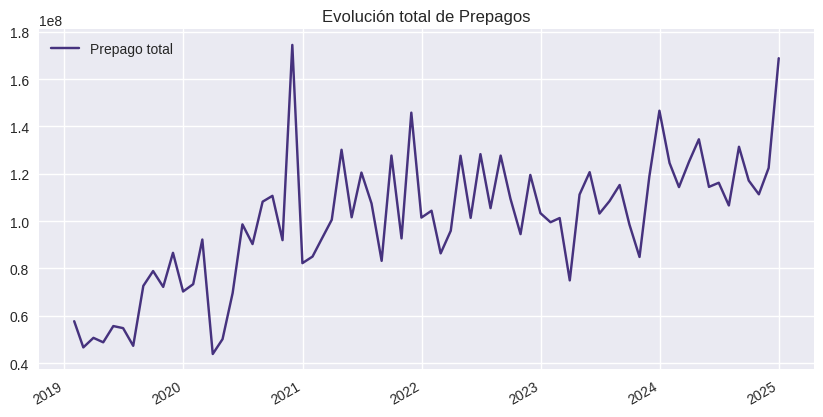

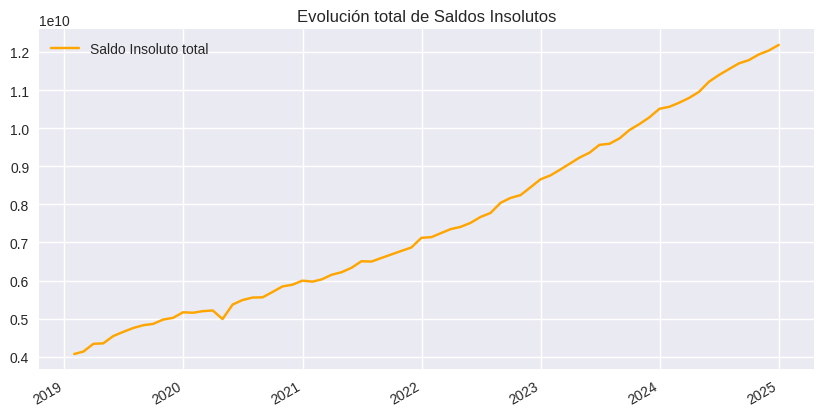

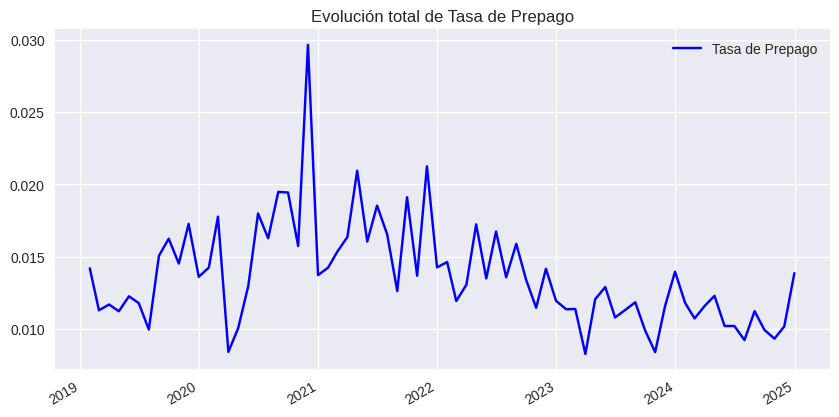

In [275]:
cols = df_saldo.columns
fecha_cols = cols[13:]

prepago_ts = df_prepago[fecha_cols].sum()
saldo_ts = df_saldo[fecha_cols].sum()
tasa_prepago_ts = prepago_ts / saldo_ts

plt.figure(figsize=(10,5))
prepago_ts.plot(label="Prepago total")
plt.title("Evolución total de Prepagos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
saldo_ts.plot(label="Saldo Insoluto total", color="orange")
plt.title("Evolución total de Saldos Insolutos")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
tasa_prepago_ts.plot(label="Tasa de Prepago", color="blue")
plt.title("Evolución total de Tasa de Prepago")
plt.legend()
plt.show()

## Análisis multivariante

En primer lugar, observamos una matriz de correlación entre las variables.

Considerando la siguiente clasificación en cuanto a la correlación, se obtienen las siguientes conclusiones.

- 0.00-0.09 correlación casi nula
- 0.10-0.19 correlación muy débil
- 0.20-0.39 correlación débil
- 0.40-0.59 correlación moderada
- 0.60-0.79 correlación fuerte
- 0.80-1.00 correlación muy fuerte


Conclusiones

- La edad del cliente muestra correlación positiva muy débil con la proporción del enganche y con la cantidad otorgada (a mayor edad, mayor porcentaje de enganche y mayor cantidad otorgada), lo que hace sentido, pues a mayor edad es probable un mayor ingreso y por tanto mayor capacidad de pago inicial. También muestra correlación negativa muy débil con la tasa y débil con el plazo del crédito (a mayor edad, menor tasa y menor plazo). Es probable que a menor edad, cuentan con un ingreso mensual menor y, por tanto, solicitan créditos a mayor plazo para disminuir el monto de pago mensual. Por otro lado, hace sentido la relación de a mayor plazo, mayor tasa, de hecho estas dos variables tienen correlación positiva moderada (0.52), y por esta razón se observa que a menor edad, una mayor tasa.

- La proporción de enganche va de la mano con esta teoría, pues muestra una relación negativa débil con el plazo y la tasa, es decir, también a mayor enganche, menor plazo y por tanto, menor tasa.

- La cantidad otorgada muestra moderada correlación positiva con enganche y prepago total, esto tiene sentido y es un caso de colinealidad. Por tanto, tiene sentido trabajar con las proporciones del prepago y del enganche sobre la cantidad otorgada para una mayor simplificación.

- Por último, el score muestra una correlación muy débil con la proporción del prepago (a mayor score, menor prepago total sobre cantidad otorgada). Esto pudiera parecer no tener mucho sentido, pero pudiera explicarse por los clientes que mudan a otros bancos, y por tanto, tienen mayor prepago, para buscar reestructuras y mejores opciones si se les dificulta cumplir con los pagos establecidos.

In [276]:
num_vars = ["edad_cliente","cantidad_otorgada","enganche","score","tasa","plazo_original", "prepago_total", "prepago_ratio", "enganche_ratio"]
cat_vars = ["estado_civil","clasificacion", "estado", "estatus_dic", "prepago_dic"]

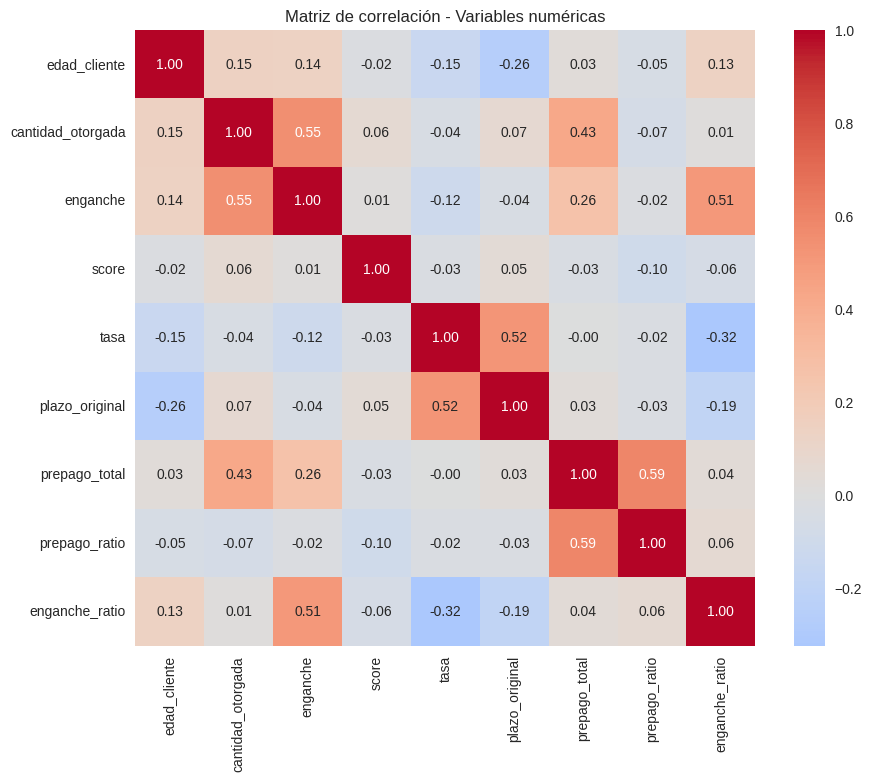

In [277]:
corr_matrix = df[num_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            cbar=True)

plt.title("Matriz de correlación - Variables numéricas")
plt.show()

El siguiente gráfico muestra visualmente la relación antes mencionada, a mayor edad, mayor cantidad otorgada (aunque cabe mencionar que a partir de cierta edad, la cantidad otorgada tiende a disminuir, indicando probablemente una relación cuadrática y no lineal). También, a mayor edad, mayor proporción del enganche.

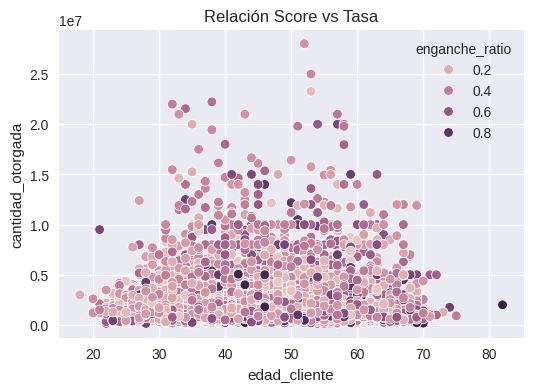

In [278]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="edad_cliente", y="cantidad_otorgada", hue="enganche_ratio")
plt.title("Relación Score vs Tasa")
plt.show()

La siguiente figura muestra un elemento clave, la diferencia en la proporción del prepago entre créditos liquidados y vigentes, por lo que a continuación, se realizarán dos matrices de correlación, una para los créditos liquidados y otra para los vigentes, en donde se comprueba que a grandes razgos se cumplen las relaciones descritas anteriormente en ambos grupos.

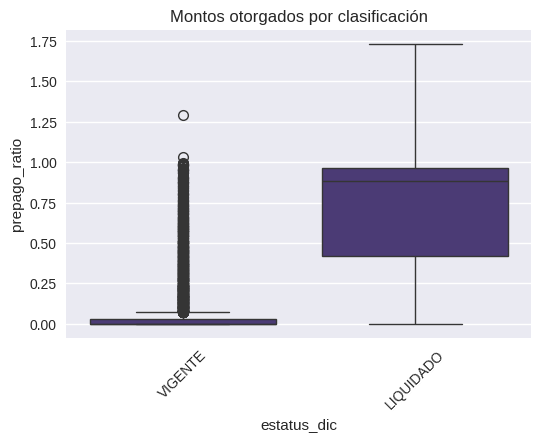

In [279]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="estatus_dic", y="prepago_ratio")
plt.xticks(rotation=45)
plt.title("Montos otorgados por clasificación")
plt.show()

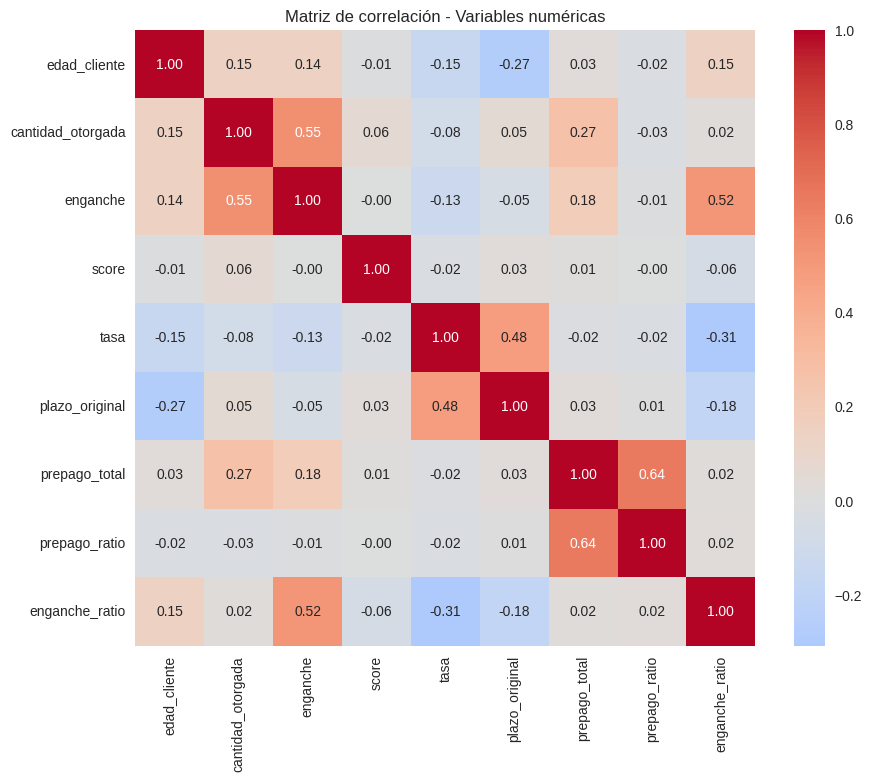

In [280]:
corr_matrix = df_vigentes[num_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            cbar=True)

plt.title("Matriz de correlación - Variables numéricas")
plt.show()

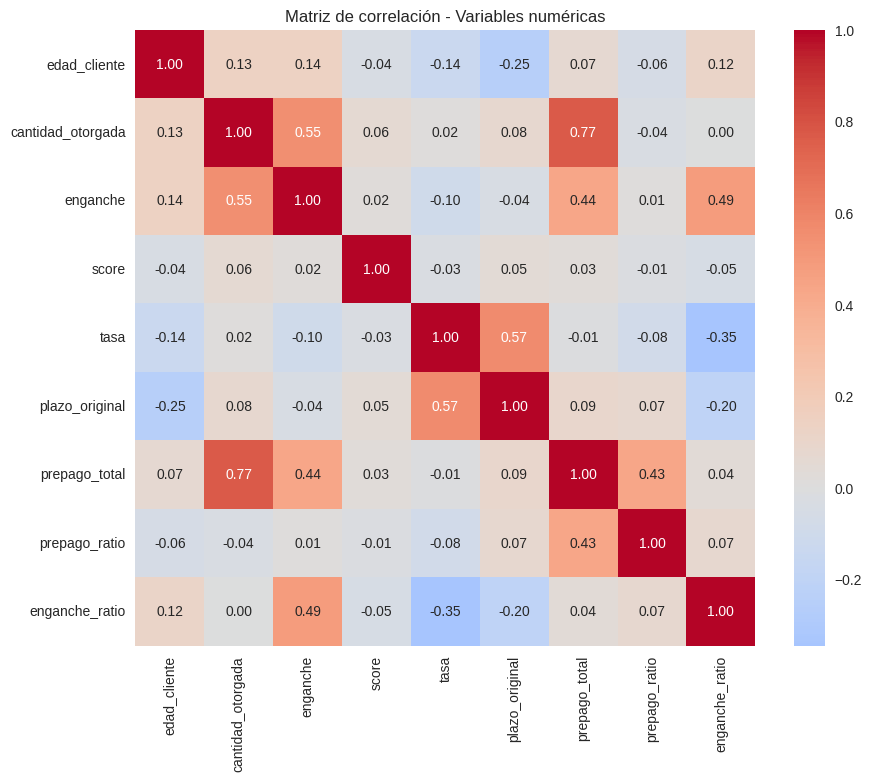

In [281]:
corr_matrix = df_liquidados[num_vars].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            cbar=True)

plt.title("Matriz de correlación - Variables numéricas")
plt.show()

Ahora observaremos, dentro de los créditos vigentes a diciembre, en qué variables difieren los créditos donde ocurre el prepago a diciembre contra los que no prepagan en diciembre.

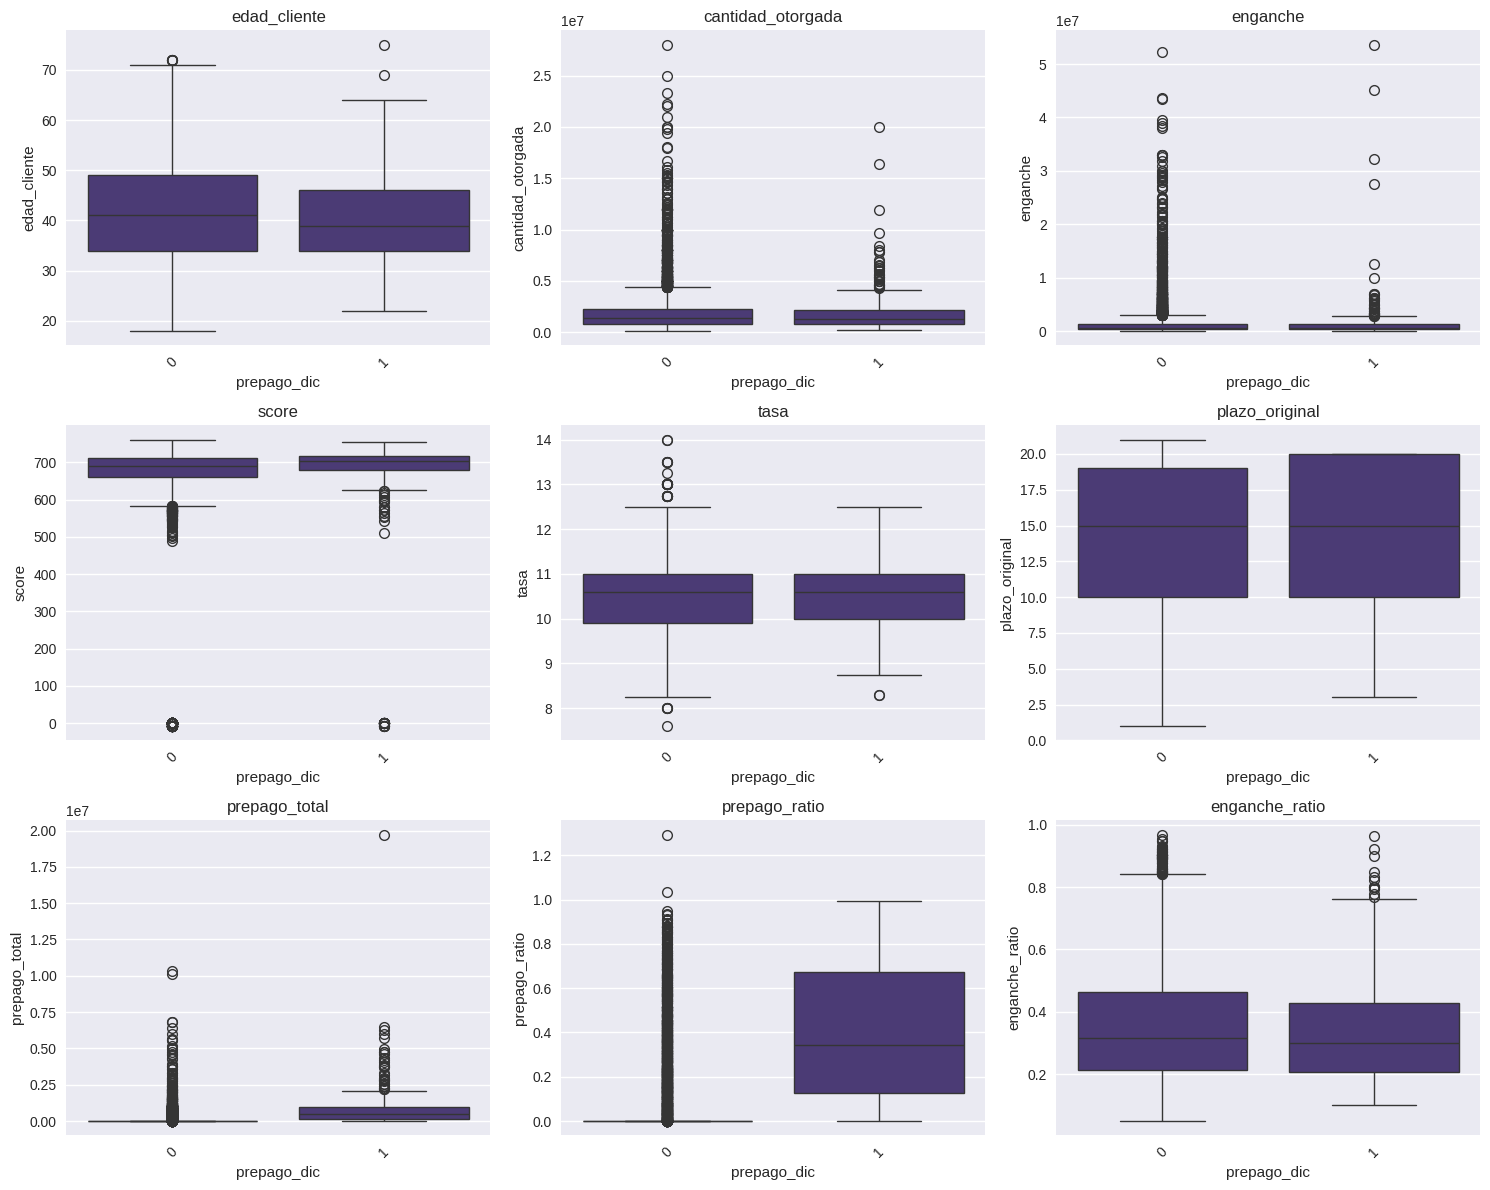

In [282]:
n_cols = 3
n_rows = 3

plt.figure(figsize=(15, 12))

# Recorremos cada variable numérica y graficamos su boxplot
for i, col in enumerate(num_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df[df["estatus_dic"] == "VIGENTE"], x="prepago_dic", y=col)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

En los gráficos anteriores se observan a nivel general las siguientes conclusiones sobre las distribuciones en los que prepagan a diciembre:

- tienen una edad media menor (contra los que no prepagan en diciembre)
- cantidad otorgada menor
- score ligeramente mayor
- tasas similares, aunque no incluye aquellos créditos con tasas muy bajas
- plazos en general mayores
- un mayor prepago total en proporción a la cantidad otorgada (es decir, muy probablemente han prepagado antes)
- una proporción de enganche menor

## Preprocesamiento

Para el preprocesamiento sobre valores nulos, atípicos o alta cardinalidad se decidieron las siguientes estrategias.

### Valores Nulos

No hay valores nulos en esta base de datos, los encontrados en las columnas de fechas significan que el crédito no estaba activo o aún no existía a esa fecha.

Sin embargo, existe un problema con la cantidad de clientes que no cuentan con historial crediticio, y por tanto cuentan con un score de 0 o negativo. A continuación se observa la cantidad de dichos scores.

In [283]:
total = len(df)
count_score = (df["score"] <= 0).sum()
pct_score = count_score / total * 100

total_v = len(df_vigentes)
count_score_v = (df_vigentes["score"] <= 0).sum()
pct_score_v = count_score_v / total_v * 100

print("Datos Totales")
print(f"Cantidad de scores <= 0: {count_score}")
print(f"Porcentaje respecto al total: {pct_score:.2f}%")

print("Datos Vigentes")
print(f"Cantidad de scores <= 0: {count_score_v}")
print(f"Porcentaje respecto al total: {pct_score_v:.2f}%")

Datos Totales
Cantidad de scores <= 0: 1727
Porcentaje respecto al total: 13.42%
Datos Vigentes
Cantidad de scores <= 0: 736
Porcentaje respecto al total: 9.75%


Como estos valores implican la falta de historial crediticio, y están muy lejos del valor mínimo observado de los que sí tienen score mayor a cero, se decisión imputarlos con este valor mínimo.

Esto asegura que estos clientes no reciben una mayor calificación por tener falta de historial, y también respeta el rango establecido por los clientes que sí cuentan con un score.

Este valor mínimo es igual a 461:

In [284]:
df[df["score"] > 0]["score"].min()

461

In [285]:
#imputación

df["score"] = df["score"].apply(lambda x: 461 if x <= 0 else x)

In [286]:
df["score"].min()

461

Cabe mencionar, que aunque se pudiera determinar un mínimo con base en algunas otras variables, decidimos mantenernos con una posición conservadora de riesgo al no otorgar una mayor calificación a clientes sin suficiente historial.

La siguiente imagen muestra como podría variar el score en base a distintas variables, pero ninguna es lo suficientemente relación es lo suficientemente fuerte.

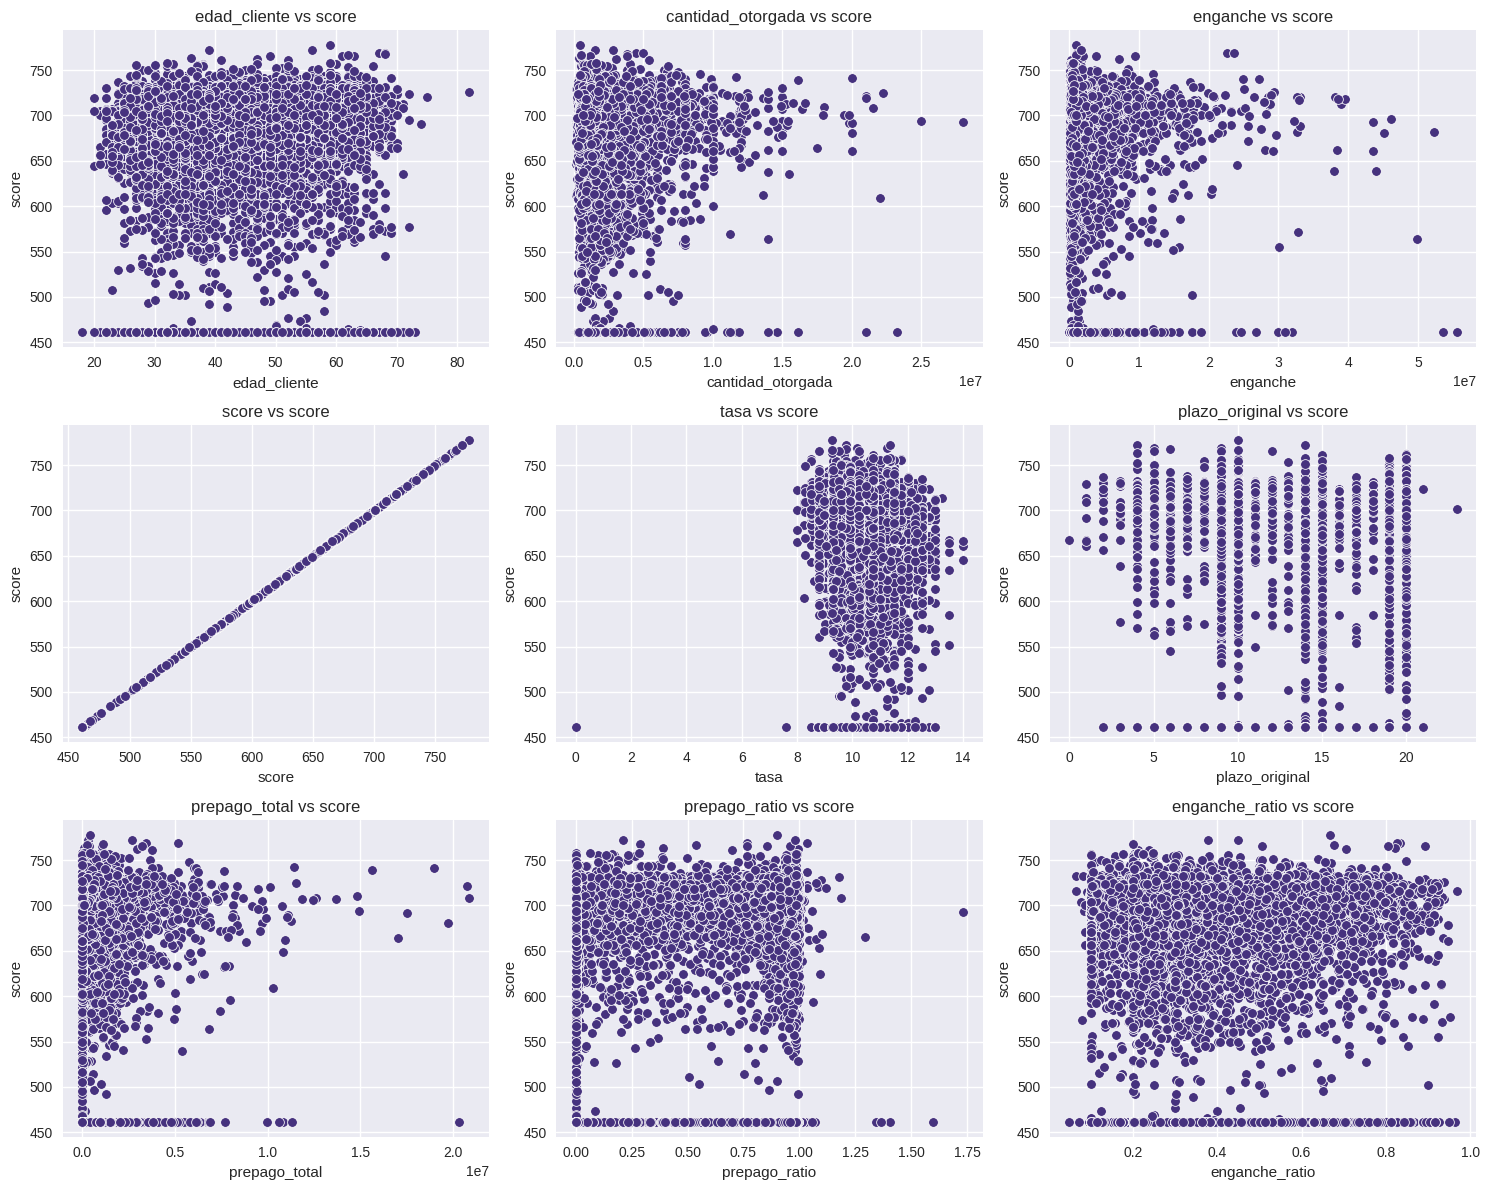

In [287]:
n_cols = 3
n_rows = 3

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(num_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df[df["score"] > 0], x=col, y="score")
    plt.title(f"{col} vs score")
    plt.tight_layout()

plt.show()

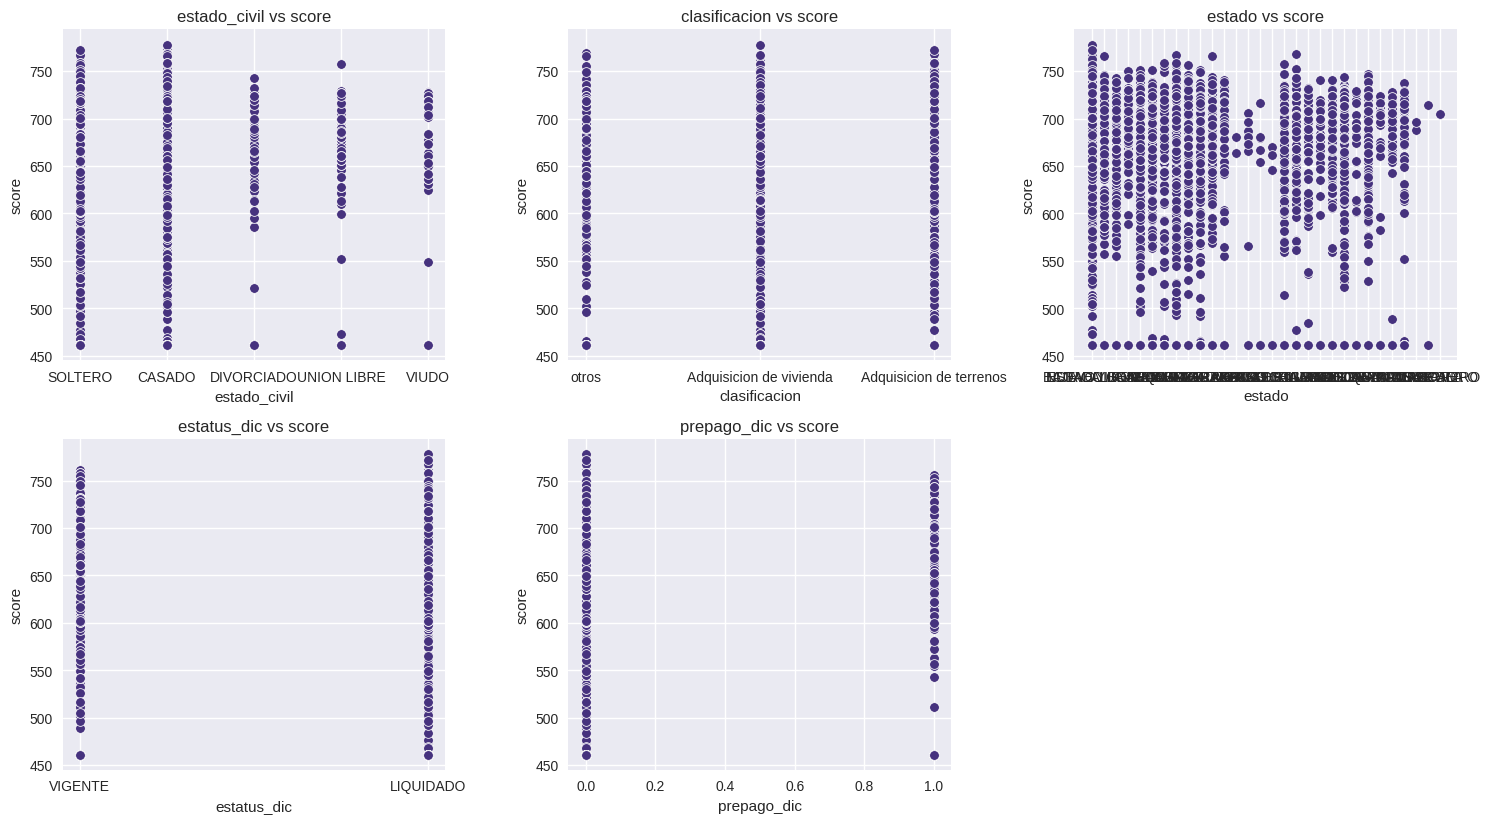

In [288]:
cols
n_cols = 3
n_rows = 3

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(cat_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df[df["score"] > 0], x=col, y="score")
    plt.title(f"{col} vs score")
    plt.tight_layout()

plt.show()

### Valores atípicos

En el análisis anterior observamos valores atípicos únicamente en la tasa, con un crédito con tasa 0. En el siguiente paso nos aseguramos que no existan valores atípicos en las demás variables. Como los datos tienen mucha variación, se utilizan los percentiles 10% y 90%.

Cabe mencionar que no consideramos como atípicos los asociados a cantidad_otorgada, enganche o prepago_total, porque serán considerados los dos últimos como proporción de la cantidad otorgada.

In [289]:

for col in num_vars:
  Q1 = df[col].quantile(0.10)
  Q3 = df[col].quantile(0.90)
  IQR = Q3 - Q1
  outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
  print(f"Variable: {col}")
  print(f"Número de Outliers: {len(outliers)} \n")

Variable: edad_cliente
Número de Outliers: 0 

Variable: cantidad_otorgada
Número de Outliers: 196 

Variable: enganche
Número de Outliers: 402 

Variable: score
Número de Outliers: 0 

Variable: tasa
Número de Outliers: 1 

Variable: plazo_original
Número de Outliers: 0 

Variable: prepago_total
Número de Outliers: 259 

Variable: prepago_ratio
Número de Outliers: 0 

Variable: enganche_ratio
Número de Outliers: 0 



Al ser solamente un crédito con tasa 0,  que además ya ha sido liquidado, este quedará excluido del análisis.

In [290]:
df[df["tasa"] == 0]

,pla_credit,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,plazo_original_meses,estado,prepago_total,estatus_dic,prepago_dic,prepago_ratio,enganche_ratio
8289,200940090040002,30,SOLTERO,1600000.0,1908000.0,otros,461,0.0,20,240,AGUASCALIENTES,0.0,LIQUIDADO,0,0.0,0.5439


In [291]:
df = df[df["tasa"] != 0]

In [292]:
df[df["tasa"] == 0]

,pla_credit,edad_cliente,estado_civil,cantidad_otorgada,enganche,clasificacion,score,tasa,plazo_original,plazo_original_meses,estado,prepago_total,estatus_dic,prepago_dic,prepago_ratio,enganche_ratio


### Cardinalidad

Tenemos problemas de alta cardinalidad para las variables de 'estado' y para 'estado_civil'.

Para el caso de 'estado_civil' se decidió incluir solamente los valores de 'SOLTERO' y 'OTRO', en donde 'OTRO' incluye 'CASADO', 'UNIÓN LIBRE', 'DIVORCIADO' y 'VIUDO'. Pues estos últimos 3 tienen muy poca frecuencia en comparación de los primeros dos, además de que tienen una mayor similitud con el estado de 'CASADO'.

Text(0.5, 1.0, 'Frecuencias de Estado Civil')

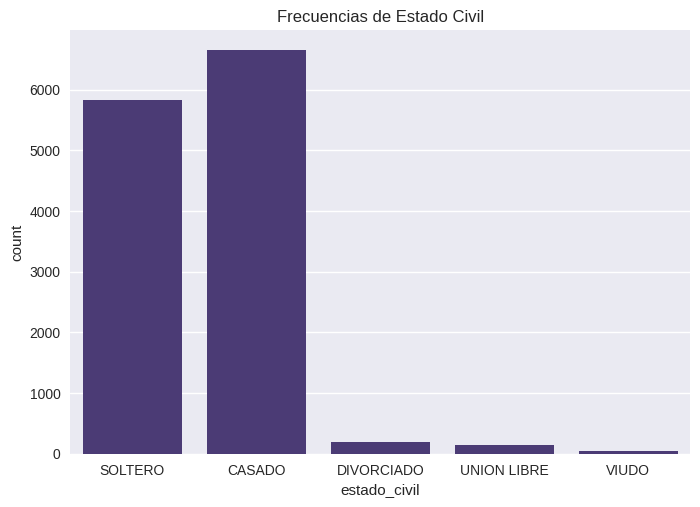

In [293]:
sns.countplot(data=df, x="estado_civil")
plt.title(f"Frecuencias de Estado Civil")

In [294]:
df["estado_civil_simplificado"] = np.where(df["estado_civil"] == "SOLTERO", "SOLTERO", "OTROS")

Text(0.5, 1.0, 'Frecuencias de Estado Civil Simplificado')

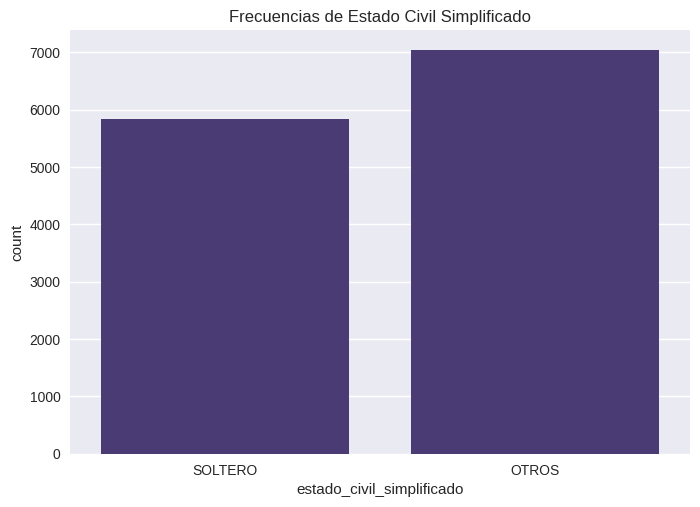

In [295]:
sns.countplot(data=df, x="estado_civil_simplificado")
plt.title(f"Frecuencias de Estado Civil Simplificado")

Por último, para la alta cardinalidad de los estados de la república, se decidió establecer regiones, con las siguientes consideraciones:



In [296]:
print(f"\nFrecuencias de Estados:")
print(df["estado"].value_counts())


Frecuencias de Estados:
estado
NUEVO LEON                         4223
JALISCO                            1742
QUERETARO                           825
COAHUILA DE ZARAGOZA                750
AGUASCALIENTES                      689
GUANAJUATO                          621
SAN LUIS POTOSI                     544
SONORA                              532
ESTADO DE MEXICO                    456
CIUDAD DE MEXICO                    427
PUEBLA                              328
TAMAULIPAS                          292
BAJA CALIFORNIA                     285
CHIHUAHUA                           271
YUCATAN                             172
ZACATECAS                           142
SINALOA                             139
VERACRUZ DE IGNACIO DE LA LLAVE     120
QUINTANA ROO                        105
MICHOACAN DE OCAMPO                  68
DURANGO                              38
NAYARIT                              33
BAJA CALIFORNIA SUR                  23
MORELOS                              14
HIDALGO 

In [297]:
region_map = {
    #Nuevo Leon
    "NUEVO LEON": "Nuevo Leon",

    #Noroeste
    "BAJA CALIFORNIA": "Noroeste",
    "BAJA CALIFORNIA SUR": "Noroeste",
    "SONORA": "Noroeste",
    "SINALOA": "Noroeste",
    "CHIHUAHUA": "Noroeste",
    "DURANGO": "Noroeste",

    # Noreste
    "COAHUILA": "Noreste",
    "COAHUILA DE ZARAGOZA": "Noreste",
    "TAMAULIPAS": "Noreste",
    "ZACATECAS": "Noreste",
    "SAN LUIS POTOSI": "Noreste",
    "AGUASCALIENTES": "Noreste",

    #Bajio-Occidente
    "JALISCO": "Bajio-Occidente",
    "MICHOACAN": "Bajio-Occidente",
    "MICHOACAN DE OCAMPO": "Bajio-Occidente",
    "COLIMA": "Bajio-Occidente",
    "GUANAJUATO": "Bajio-Occidente",
    "QUERETARO": "Bajio-Occidente",
    "NAYARIT": "Bajio-Occidente",

    #Centro-Sur
    "CIUDAD DE MEXICO": "Centro-Sur",
    "CDMX": "Centro-Sur",
    "ESTADO DE MEXICO": "Centro-Sur",
    "MORELOS": "Centro-Sur",
    "HIDALGO": "Centro-Sur",
    "PUEBLA": "Centro-Sur",
    "TLAXCALA": "Centro-Sur",
    "VERACRUZ": "Centro-Sur",
    "VERACRUZ DE IGNACIO DE LA LLAVE": "Centro-Sur",
    "GUERRERO": "Centro-Sur",
    "OAXACA": "Centro-Sur",
    "CHIAPAS": "Centro-Sur",
    "TABASCO": "Centro-Sur",
    "CAMPECHE": "Centro-Sur",
    "YUCATAN": "Centro-Sur",
    "QUINTANA ROO": "Centro-Sur",
}

# Crear la variable
df["estado_simplificado"] = df["estado"].map(region_map)

# (Opcional) manejar estados no mapeados o faltantes
df["estado_simplificado"] = df["estado_simplificado"].fillna("OTROS")

In [298]:
print(f"\nFrecuencias de Estados:")
print(df["estado_simplificado"].value_counts())


Frecuencias de Estados:
estado_simplificado
Nuevo Leon         4223
Bajio-Occidente    3296
Noreste            2417
Centro-Sur         1642
Noroeste           1288
Name: count, dtype: int64


Text(0.5, 1.0, 'Frecuencias de Estado Simplificado')

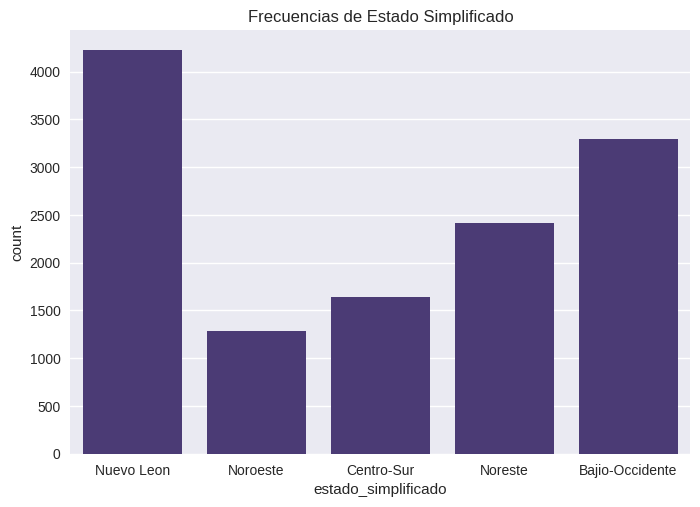

In [299]:
sns.countplot(data=df, x="estado_simplificado")
plt.title(f"Frecuencias de Estado Simplificado")

## Conclusiones

A través de este análisis se pueden resumir las siguientes conclusiones:

- Se observa una correlación positiva entre la edad del cliente y la proporción del enganche y la cantidad otorgada, así como una correlación negativa entre la edad del cliente y la tasa y el plazo.
- Con base en la teoría financiera, tiene sentido la correlación positiva entre plazo y tasa. También la correlación negativa entre la proporción del enganche y plazo.
- Es probable que los clientes de menor edad, al contar con menor ingreso mensual, soliciten los créditos a mayor plazo para reducir el pago mensual. Esto ocasiona su relación negativa con el plazo y, por tanto, con la tasa.
- El score muesta una correlación negativa con la proporción del prepago total, así como una correlación positiva con la cantidad otorgada cuando no se consideran los scores iguales o menores a cero.
- Los scores menores o iguales a cero se decidió imputarlos con el valor mínimo observado en el resto de los clientes. Esto es para mantener una posición conservadora de riesgo al no otorgar mayor calificación cuando falta historial crediticio.
- Se observó un valor atípico de tasa igual a cero. Al ser únicamente un crédito en este caso, se decidió excluirlo del análisis.
- El estado civil, contaba con muy baja frecuencia en los valores de 'UNIÓN LIBRE', 'DIVORCIADO', y 'VIUDO'. Por esta razón, se decidió incluirlos con los 'CASADOS' en una clasificación de 'OTROS' con ligeramente mayor frecuencia que la de 'SOLTERO'.
- Por último, los estados de la república se agruparon en regiones de tamaño importante, para evitar la alta cardinalidad.